# Assignment 2
## Create a Neural Network using PyTorch for FashionMNIST dataset

In [ ]:
%matplotlib inline



# NN with PyTorch

PyTorch has two primitives to work with data <https://pytorch.org/docs/stable/data.html>: 
- ``torch.utils.data.DataLoader`` and 
- ``torch.utils.data.Dataset``.

``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.




### Import the necessary libraries

In [20]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as 
- `TorchText <https://pytorch.org/text/stable/index.html>`_, 
- `TorchVision <https://pytorch.org/vision/stable/index.html>`_, and 
- `TorchAudio <https://pytorch.org/audio/stable/index.html>`_, 
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like 
CIFAR, COCO (`full list here <https://pytorch.org/docs/stable/torchvision/datasets.html>`_). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



### Download training data from open datasets

In [21]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

### Download test data from open datasets

In [22]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element 
in the dataloader iterable will return a batch of 64 features and labels.



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


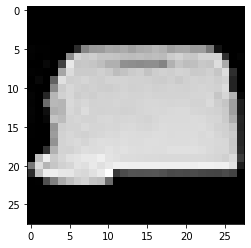

Label: 8


In [23]:
batch_size = 64

# Create data loaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")




--------------




Creating Models
------------------
To define a neural network in PyTorch, we create a class that inherits 
from `nn.Module <https://pytorch.org/docs/stable/generated/torch.nn.Module.html>`_. 

We define the layers of the network in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. 

To accelerate operations in the neural network, we move it to the GPU if available.



### Get cpu or gpu device for training

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define model
- Flatten the image
- Sequential Layers
    - Linear layer
    - ReLU layer

In [25]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

--------------




Optimizing the Model Parameters
----------------------------------------
To train a model, we need
- `loss function` <https://pytorch.org/docs/stable/nn.html#loss-functions>
- `optimizer` <https://pytorch.org/docs/stable/optim.html> 



In [26]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and 
backpropagates the prediction error to adjust the model's parameters. 



In [27]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [28]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns 
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304220  [    0/60000]
loss: 2.283556  [ 6400/60000]
loss: 2.268587  [12800/60000]
loss: 2.259439  [19200/60000]
loss: 2.244332  [25600/60000]
loss: 2.226686  [32000/60000]
loss: 2.207050  [38400/60000]
loss: 2.205326  [44800/60000]
loss: 2.186641  [51200/60000]
loss: 2.140089  [57600/60000]
Test Error: 
 Accuracy: 48.7%, Avg loss: 0.033806 

Epoch 2
-------------------------------
loss: 2.119968  [    0/60000]
loss: 2.146557  [ 6400/60000]
loss: 2.122552  [12800/60000]
loss: 2.083463  [19200/60000]
loss: 2.083522  [25600/60000]
loss: 2.067624  [32000/60000]
loss: 2.008271  [38400/60000]
loss: 1.969115  [44800/60000]
loss: 1.904613  [51200/60000]
loss: 1.947462  [57600/60000]
Test Error: 
 Accuracy: 55.0%, Avg loss: 0.029941 

Epoch 3
-------------------------------
loss: 1.883143  [    0/60000]
loss: 1.876971  [ 6400/60000]
loss: 1.853162  [12800/60000]
loss: 1.804536  [19200/60000]
loss: 1.817919  [25600/60000]
loss: 1.655993  [32000/600

--------------




Saving Models
-------------
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [15]:
import torch
import torch.onnx as onnx
import torchvision.models as models

model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading Models
----------------------------

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it. 



In [16]:
model = models.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

This model can now be used to make predictions.



In [30]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
